In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import humanize
import matplotlib.pyplot as plt 
import pickle
from ast import literal_eval

In [26]:
def save_as_pickle(file_path, file):
    with open(file_path, 'wb') as f:
        pickle.dump(file, f)

def load_from_pickle(file_path):
    with open(file_path, 'rb') as f:
        file = pickle.load(f)
    return file

def dropunamed(df):
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    return df

def print_df(df, target_col = None):
    print(f"df.shape: {df.shape}")
    print(f"df.columns: {df.columns}")
    print(f"df size: {humanize.naturalsize(df.memory_usage().sum())}")
    if not target_col==None:
        print(df['target'].value_counts())
        
def get_extension_files(path_to_json, ext='.json'):
    json_files = [os.path.join(path_to_json, pos_json) for pos_json in os.listdir(path_to_json) if pos_json.endswith(ext)]
    return json_files

def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def imshow_all_predictions(df, vname, num_img_per_prof = 3, resize_shape = (50, 50)):
    vertical_images=[]
    prof_names_list = literal_eval(df[df["vname"]==vname]["unique"].iloc[0].replace("\n", "").replace("\' \'", "\', \'"))
    for prof_name in prof_names_list:
        folder_name = prof_name_2_folder_name_dict[prof_name]
        folder_path = os.path.join(known_faces_dir, str(folder_name))
        img_path_list = get_extension_files(folder_path, ext=".jpg")[:num_img_per_prof]
        images=[]
        for img_path in img_path_list:
            img = cv2.imread(img_path)
            img = img[:, :, ::-1]
            img=cv2.resize(img, resize_shape) 
            hside=get_side(img, side_type="horizontal")
            images.append(img)
            images.append(hside)
        himage=np.hstack((images))
        vside=get_side(himage, side_type="vertical")
        vertical_images.append(himage)
        vertical_images.append(vside)

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{num_img_per_prof} labeled faces per predicted professor")
    plt.imshow(gallery.astype(np.uint8))

In [3]:
base_dir = 'D:\\nptel_face_recognition'
data_dir = os.path.join(base_dir, 'data')
known_faces_dir = os.path.join(data_dir, 'known_faces')
full_vedios_dir = os.path.join(data_dir, 'full_vedio')
pkl_files_dir = os.path.join(data_dir, "pkl_files")
csv_files_dir = os.path.join(data_dir, "csv_files")

folder_name_2_prof_name_dict = load_from_pickle(os.path.join(pkl_files_dir, "folder_name_2_prof_name_dict.pkl"))
prof_name_2_folder_name_dict = {v: k for k, v in folder_name_2_prof_name_dict.items()}


In [4]:
df = pd.read_csv(os.path.join(csv_files_dir, "face_recognition_results.csv"))

# takes 1 minute to load the pickle file
# df = pd.read_pickle(os.path.join(pkl_files_dir, "face_recognition_results.pkl"))
df = dropunamed(df)

In [5]:
print_df(df)

df.shape: (52, 13)
df.columns: Index(['vname', 'nptel_channel_name', 'playlistn', 'vedio_path', 'true_name',
       'accuracy', 'number of predictions', 'time', 'unique', 'counts',
       'frame_list', 'frame_index_list', 'names_list'],
      dtype='object')
df size: 5.5 kB


In [10]:
df.head()

,vname,nptel_channel_name,playlistn,vedio_path,true_name,accuracy,number of predictions,time,unique,counts,frame_list,frame_index_list,names_list
0,ZDQBcuVRWYs.mp4,Aerospace Engineering,Jet and Rocket Propulsion,/content/drive/My Drive/nptel_face_recognition...,dr. a. kushari,0.92,50,10.579813,['dr. a. kushari' 'prof s. de' 'prof. debashis...,[46 2 1 1],"[array([[[2, 2, 2],\n [2, 2, 2],\n ...","[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...","['dr. a. kushari', 'dr. a. kushari', 'dr. a. k..."
1,QLcxx6MJnbA.mp4,Aerospace Engineering,Jet and Rocket Propulsion,/content/drive/My Drive/nptel_face_recognition...,dr. a. kushari,0.84,50,7.708869,['dr. a. kushari' 'prof s. de' 'prof. amit bas...,[42 1 1 1 4 1],"[array([[[0, 0, 0],\n [0, 0, 0],\n ...","[16, 17, 18, 19, 20, 21, 40, 41, 42, 43, 44, 4...","['dr. a. kushari', 'dr. a. kushari', 'dr. a. k..."
2,YrkbOeF7wFw.mp4,Aerospace Engineering,Jet and Rocket Propulsion,/content/drive/My Drive/nptel_face_recognition...,dr. a. kushari,0.30,50,14.564180,['dr. a. kushari' 'prof s. de' 'prof. amit bas...,[15 8 1 8 1 1 12 4],"[array([[[2, 2, 2],\n [2, 2, 2],\n ...","[16, 17, 18, 19, 20, 21, 22, 23, 24, 42, 43, 4...","['dr. a. kushari', 'dr. a. kushari', 'dr. a. k..."
3,2K0EJaimBas.mp4,Aerospace Engineering,Turbomachinery Aerodynamics,/content/drive/My Drive/nptel_face_recognition...,prof. bhaskar ot,0.98,50,4.840185,['dr. ton er' 'prof. bhaskar ot'],[ 1 49],"[array([[[0, 0, 0],\n [0, 0, 0],\n ...","[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...","['prof. bhaskar ot', 'prof. bhaskar ot', 'prof..."
4,utL9RWUdVVs.mp4,Aerospace Engineering,Turbomachinery Aerodynamics,/content/drive/My Drive/nptel_face_recognition...,prof. bhaskar ot,1.00,50,4.846596,['prof. bhaskar ot'],[50],"[array([[[4, 1, 2],\n [4, 1, 2],\n ...","[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...","['prof. bhaskar ot', 'prof. bhaskar ot', 'prof..."


In [11]:
print(f'total vedios: {df.shape[0]}\nmean acuracy: {df["accuracy"].mean()}\n\
num of nans: {df[df["accuracy"].isna()].shape[0]}\nnum of perfect accuracy: {df[df["accuracy"]==1].shape[0]}')

total vedios: 52
mean acuracy: 0.7858143244962427
num of nans: 0
num of perfect accuracy: 18


(array([ 4.,  2.,  1.,  1.,  3.,  2.,  0.,  2.,  2., 35.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

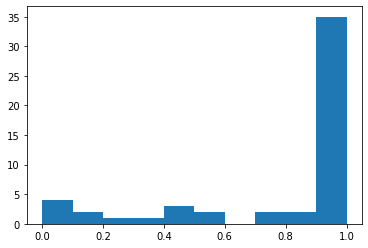

In [30]:
plt.hist(df["accuracy"])

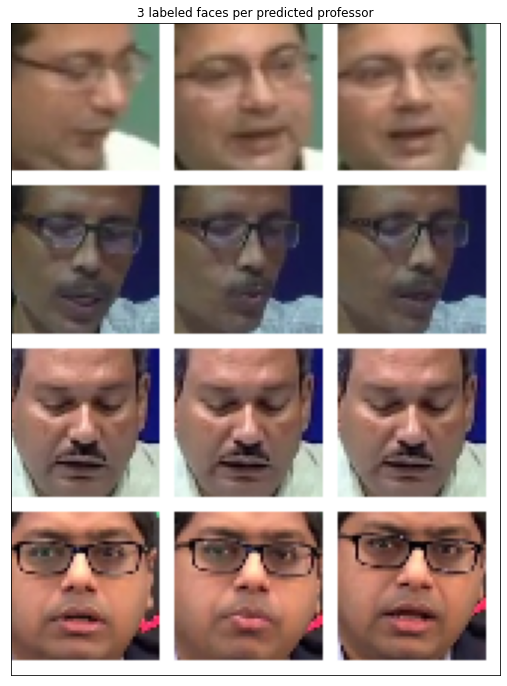

In [29]:
# show sample images for all predicetd profs for a vedio

imshow_all_predictions(df, "Vnxy8BcCTUc.mp4")